In [1]:
import pandas as pd
import numpy as np
import glob
import os
import datetime
import sqlite3
import pricesdb
import json
import pprint
import importlib
import newsdb

In [2]:
importlib.reload(pricesdb)
importlib.reload(newsdb)


<module 'newsdb' from 'c:\\Users\\baerw\\Documents\\Projekte\\Gitlocal\\L1trendchanges\\newsdb.py'>

Laden der topholdings, die letzten 20 news zu jeder Holding von seekingalpha holen und in die newsdb speichern

In [3]:
# Symbols aus Watchlist
watchlist = pd.read_csv('watchlist.csv', sep=';')
groupl = [10,40] #[20,30] haben sowieso keine Holdingliste

controllist = watchlist[watchlist['group'].isin(groupl)].reset_index()
print(controllist[['index','yahoo_symbol','region','group']])
 

    index yahoo_symbol region  group
0       0         ACWI     US   10.0
1       1         URTH     US   10.0
2       2         ^NDX     US   10.0
3       4        ^GSPC     US   10.0
4       6         ^RUT     US   10.0
5       7         ^DJR     US   10.0
6       8        ^N225     JP   10.0
7      10         ^HSI     HK   10.0
8      12       ^BSESN     US   10.0
9      13        ^SSMI     US   10.0
10     17       ^GDAXI     US   10.0
11     39         BFIT     US   40.0
12     40         SOCL     US   40.0
13     43          LIT     US   40.0
14     44         MILN     US   40.0
15     45     LYDAX.SW     US   40.0
16     47         ROBO     US   40.0
17     50          IGV     US   40.0
18     51      WTAI.SW     US   40.0
19     52      ICHN.SW     US   40.0
20     53      INRG.SW     US   40.0
21     54     LYNRJ.SW     US   40.0
22     55      XDEV.SW     US   40.0
23     56      IWMO.SW     US   40.0
24     57      XDEM.SW     US   40.0
25     60      HTRY.SW     US   40.0
2

In [4]:
# die topholdings der watchlist ETFs aus der DB holen und aggregieren
agg_tophdf = pd.DataFrame()
for i in range(len(controllist)):
    f = glob.glob(r"data/"+controllist['yahoo_symbol'][i] + "_*.db")[0]
    tophdf, _, _ = pricesdb.get_topholdings_from_db(f)
    if tophdf is not None:
        tophdf['yahoo_symbol'] = controllist['yahoo_symbol'][i]
        agg_tophdf = pd.concat([agg_tophdf,tophdf])
agg_tophdfdddf = agg_tophdf['symbol'].drop_duplicates()
print(agg_tophdfdddf)
querylist = list(agg_tophdfdddf)

db_file:data\ACWI_US.db
db_file:data\URTH_US.db
db_file:data\^NDX_US.db
data\^NDX_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^GSPC_US.db
data\^GSPC_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^RUT_US.db
data\^RUT_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^DJR_US.db
data\^DJR_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^N225_JP.db
data\^N225_JP.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^HSI_HK.db
data\^HSI_HK.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^BSESN_US.db
data\^BSESN_US.db Key: jsond['quoteSummary']['result'][0]['topHoldings']['holdings'] does not exist
db_file:data\^SSMI_US.db
data\^SSMI_US.db Key: jsond['quoteSummary']['result'][0]['topHold

In [5]:
# die jeweils letzten 20 news der topholdings aus seekingalpha holen und in die Tabelle list_by_symbol speichern
conn, _  = newsdb.create_connection('data/seeking-alpha.db')
for symbol in querylist:
    list_by_symboldf, response = newsdb.get_news_list_by_symbol(symbol)
    if list_by_symboldf is not None and list_by_symboldf.shape != (0,0) :
        newsdb.insert_list_by_symbol(conn, f'{symbol}', list_by_symboldf)
conn.close()

db_file:data/seeking-alpha.db
GOOGL: 19 rows/news inserted
GOOG: 19 rows/news inserted
AMZN: 19 rows/news inserted
AAPL: 19 rows/news inserted
XOM: 19 rows/news inserted
META: 19 rows/news inserted
near "more": syntax error 
insert_sql: INSERT INTO list_by_symbol ('id', 'symbol', 'dtupdate', 'type', 'attributes.publishOn', 'attributes.isLockedPro', 'attributes.commentCount', 'attributes.gettyImageUrl', 'attributes.videoPreviewUrl', 'attributes.title','attributes.isPaywalled', 'relationships.author.data.id','relationships.author.data.type', 'relationships.sentiments.data','relationships.primaryTickers.data', 'relationships.secondaryTickers.data', 'relationships.otherTags.data','links.self') 
                        values ( 
                    "3978944", 
                    "MSFT",
                    "2023-06-11",
                    "news", 
                    "2023-06-09T09:26:45-04:00", 
                    False,
                    46, 
                    "https://static.seeki

Die titles aus den news und mit FinBert den sentiment bewerten und in die newsdb speichern

In [6]:
conn, _  = newsdb.create_connection('data/seeking-alpha.db')

db_file:data/seeking-alpha.db


In [23]:
def create_table_sentiment_title_list(conn):
	create_table = """CREATE TABLE sentiment_title_list (
		'id' INTEGER PRIMARY KEY, 
		'sentiment' TEXT,
		'modelname' TEXT,
		'dtupdate'     TIMESTAMP);"""
	try:
		c = conn.cursor()
		c.execute(create_table)
		#c.execute(create_table_pk)
		return conn
	except sqlite3.Error as e:
		print(str(e) + '/n failed sql:' + create_table)
	return conn


In [3]:
create_table_sentiment_title_list(conn)

NameError: name 'create_table_sentiment_title_list' is not defined

In [7]:
sql = """select id, "attributes.publishOn", "attributes.title" 
            from list_by_symbol
            where id not in (select id from sentiment_title_list)"""

sentimentdf  = pd.read_sql(sql, conn)


In [9]:
def insert_sentiment_title_list(conn, dfsentiment, modelname= 'yiyanghkust/finbert-tone'):
    cursor = conn.cursor()
    idl = list(dfsentiment['id'])
    selsql = f"""select id from sentiment_title_list where id in ({str(idl)[1:-1]}) and modelname = '{modelname}'"""
    ids = pd.read_sql(selsql, conn)
    delsql = f"""delete from sentiment_title_list where id in ({str(list(ids['id']))[1:-1]}) and modelname = '{modelname}'"""
    conn.execute(delsql)
    for index, row in dfsentiment.iterrows():
        insert_sql = f"""INSERT INTO sentiment_title_list ('id', 'sentiment', 'modelname', 'dtupdate') 
                                values ( 
                            "{row['id']}", 
                            "{row['sentiment']}",
                            "{modelname}",
                            "{datetime.datetime.today().strftime('%Y-%m-%d')}"
                            )"""
        try:
            cursor.execute(insert_sql)
        except sqlite3.Error as e:
            print(str(e) + ' \ninsert_sql: '+ insert_sql +' \nund weiter...')
            pass
    conn.commit()
    print(f'{modelname}: {str(index)} rows inserted')
    return conn


Für jeden ETF für jedes symbol die titles aus der DB selektieren und in Finbert stecken, heraus soll eine Tabelle mit newsid, symbol publishOn, sentiment kommen, zu kompliziert
Alle neuen werden gesentimented und in die sentiment_title_list geschrieben.

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

c:\Users\baerw\.conda\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = list(sentimentdf['attributes.title'])
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

# 
sentimentdf['sentiment'] = results
conn = insert_sentiment_title_list(conn, sentimentdf)

[{'label': 'Positive', 'score': 0.9997596144676208}, {'label': 'Positive', 'score': 0.9544219374656677}, {'label': 'Neutral', 'score': 0.9974038004875183}, {'label': 'Neutral', 'score': 0.9979173541069031}, {'label': 'Positive', 'score': 0.9433016777038574}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.500563383102417}, {'label': 'Neutral', 'score': 0.9999102354049683}, {'label': 'Positive', 'score': 0.9999994039535522}, {'label': 'Negative', 'score': 0.9416165947914124}, {'label': 'Positive', 'score': 0.9993267059326172}, {'label': 'Neutral', 'score': 0.9993292093276978}, {'label': 'Neutral', 'score': 0.9999977350234985}, {'label': 'Neutral', 'score': 0.9997894167900085}, {'label': 'Positive', 'score': 0.902030348777771}, {'label': 'Positive', 'score': 0.8017893433570862}, {'label': 'Negative', 'score': 0.9999995231628418}, {'label': 'Neutral', 'score': 0.9824297428131104}, {'label': 'Neutral', 'score': 0.9234724044799805}, {'label': 'Neutral', 'score': 0.9952

1340 titles in 27m 58.6 sentimented auf der CPU
<br>
387 titles in 7m 44.5

In [5]:
# Alle 
sql = """select * 
         from list_by_symbol l
         left join sentiment_title_list s on s.id = l.id
         """
sentimentdf  = pd.read_sql(sql, conn)

In [7]:
#json.dumps(sentimentdf['sentiment'][0])
sentimentvalued = [eval(x) for x in sentimentdf['sentiment']]

In [8]:
sentimentvaluedf = pd.DataFrame(sentimentvalued)

In [9]:
sentimentdf['label']= sentimentvaluedf['label']
sentimentdf['score']= sentimentvaluedf['score']

In [10]:
scatterdf = pd.merge(agg_tophdf,sentimentdf, on='symbol', how='left')

In [11]:
yahoo_symbol_scatterdf =  scatterdf[scatterdf['yahoo_symbol'] == 'ACWI'][['yahoo_symbol','attributes.publishOn','label','score']]
#yahoo_symbol_scatterdf =  scatterdf[['yahoo_symbol','attributes.publishOn','label','score']]

In [12]:
yahoo_symbol_scatterdf.dtypes

yahoo_symbol             object
attributes.publishOn     object
label                    object
score                   float64
dtype: object

In [13]:
dttimes = pd.to_datetime(scatterdf[scatterdf['yahoo_symbol'] == 'ACWI']['attributes.publishOn']).dropna()
dttimes1 = pd.to_datetime(scatterdf[scatterdf['yahoo_symbol'] == 'URTH']['attributes.publishOn']).dropna()
dttimes2 = pd.to_datetime(scatterdf['attributes.publishOn'].dropna().sort_values())

In [14]:
dttimes.dtypes, dttimes1.dtypes, dttimes2.dtypes
#dttimes1[0:10].map(pd.Timestamp.timestamp)

(datetime64[ns, pytz.FixedOffset(-240)],
 datetime64[ns, pytz.FixedOffset(-240)],
 dtype('O'))

In [15]:
yahoo_symbol_scatterdf['dttimes'] = dttimes.map(pd.Timestamp.timestamp)

In [25]:
# Define a function to summarize the label
def summarize_label(row):
    if row['label'] == 'Negative':
        return abs(row['score'] -1)
    elif row['label'] == 'Neutral':
        return 0.5
    else:
        return row['score']


In [26]:
# Apply the function to create a new column
yahoo_symbol_scatterdf['summary'] = yahoo_symbol_scatterdf.apply(lambda row: summarize_label(row), axis=1)

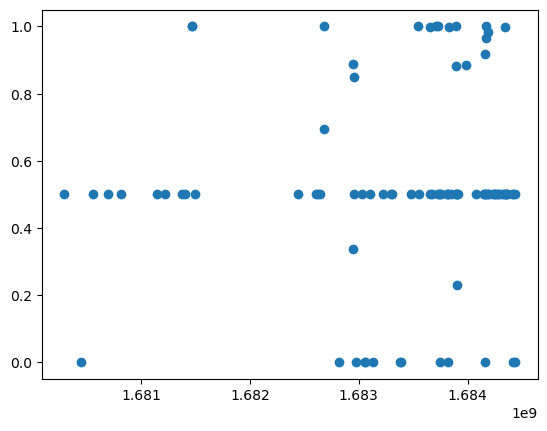

In [27]:
import matplotlib.pyplot as plt
import time

plt.scatter(yahoo_symbol_scatterdf['dttimes'], yahoo_symbol_scatterdf['summary'])

In [31]:
scatterdf.columns

Index(['symbol', 'holdingName', 'holdingPercent.raw', 'holdingPercent.fmt',
       'yahoo_symbol', 'id', 'dtupdate', 'type', 'attributes.publishOn',
       'attributes.isLockedPro', 'attributes.commentCount',
       'attributes.gettyImageUrl', 'attributes.videoPreviewUrl',
       'attributes.title', 'attributes.isPaywalled',
       'relationships.author.data.id', 'relationships.author.data.type',
       'relationships.sentiments.data', 'relationships.primaryTickers.data',
       'relationships.secondaryTickers.data', 'relationships.otherTags.data',
       'links.self', 'id', 'sentiment', 'modelname', 'dtupdate'],
      dtype='object')

In [127]:
yahoo_symbol_scatterdf

,yahoo_symbol,attributes.publishOn,label,score
0,ACWI,NaN,NaN,NaN
1,ACWI,NaN,NaN,NaN
2,ACWI,NaN,NaN,NaN
3,ACWI,2023-05-08T07:14:22-04:00,Positive,0.999606
4,ACWI,2023-05-08T10:14:54-04:00,Neutral,0.999864
...,...,...,...,...
1906,STZX.SW,NaN,NaN,NaN
1907,STZX.SW,NaN,NaN,NaN
1908,STZX.SW,NaN,NaN,NaN
1909,STZX.SW,NaN,NaN,NaN


Ab hier andere Versuche mit anderen Providern

In [3]:
import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/market/auto-complete"

querystring = {"query":"CELH:US"}

headers = {
	"X-RapidAPI-Key": os.environ.get('X_RapidAPI_Key'),
	"X-RapidAPI-Host": "bloomberg-market-and-financial-news.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"quote":[{"securityType":"Common Stock","symbol":"CELH","exchange":"NASDAQ CM","country":"United States","currency":"USD","resourceType":"Company","fundamentalDataCurrency":"USD","resourceSubtype":"Public","region":"AMERICAS","ticker":"celh:us","tickerName":"CELH:US","template":"Stock","tinyName":"Celsius Holdings Inc","name":"Celsius Holdings Inc","watchlist":true,"resourceId":"CELH:US","id":"CELH:US","title":"Celsius Holdings Inc","card":"security"}],"news":[{"title":"PIMCO US' Boxer on the Latest US Economic Data","id":"RSCZ2XT0G1KW01","card":"video","date":1680227035,"longURL":"https://www.bloomberg.com/news/videos/2023-03-31/pimco-us-boxer-on-the-latest-us-economic-data-video","thumbnailImage":"https://assets.bwbx.io/images/users/iqjWHBFdfxIU/i_b2vW1wIsUU/v3/600x-1.jpg"},{"title":"US and EU Near Critical Minerals Accord to Unlock US Subsidies","id":"RS9UAGT1UM0X01","card":"article","date":1680082787,"longURL":"https://www.bloomberg.com/news/articles/2023-03-29/us-and-eu-near-crit

In [6]:
import requests

url = "https://bloomberg-market-and-financial-news.p.rapidapi.com/stories/list"

querystring = {"template":"STOCK","id":"CELH:US"}

headers = {
	"X-RapidAPI-Key": os.environ.get('X_RapidAPI_Key'),
	"X-RapidAPI-Host": "bloomberg-market-and-financial-news.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"message":"You are not subscribed to this API."}


In [22]:
response.text

'{"stories":[{"resourceType":"Story","card":"article","title":"Fuel That Powers the Global Economy Is Flashing Recession Signs","published":1681606800,"internalID":"RSJNX6T1UM0W01","thumbnailImage":"https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iLlXRnFvwqr0/v0/600x-1.jpg","primarySite":"markets","shortURL":"https://www.bloomberg.com/news/articles/2023-04-16/softening-diesel-fuel-market-triggers-global-recession-fears","longURL":"https://www.bloomberg.com/news/articles/2023-04-16/softening-diesel-fuel-market-triggers-global-recession-fears"},{"resourceType":"Story","card":"article","title":"Glencore Digs in for Battle as Momentum Shifts Against Teck","published":1681592256,"internalID":"RT5EO2T1UM0W01","thumbnailImage":"https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iUFrLlZqqgYg/v0/600x-1.jpg","primarySite":"markets","shortURL":"https://www.bloomberg.com/news/articles/2023-04-15/glencore-boss-digs-in-for-battle-as-momentum-shifts-against-teck","longURL":"https://www.bloomberg.com/n

DIe News von yh-finance weiter unten taugt nicht so viel, denke ich

In [17]:
import requests

url = "https://yh-finance.p.rapidapi.com/news/v2/get-details"

querystring = {"uuid":"9803606d-a324-3864-83a8-2bd621e6ccbd","region":"US"}

headers = {
	"X-RapidAPI-Key": os.environ.get('X_RapidAPI_Key'),
	"X-RapidAPI-Host": "yh-finance.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"data":{"contents":[{"content":{"id":"9803606d-a324-3864-83a8-2bd621e6ccbd","isHosted":false,"contentType":"STORY","canonicalUrl":{"url":"https://www.investors.com/market-trend/stock-market-today/dow-jones-futures-stock-market-rally-strategy-tesla-dives-on-sp-500-surprise/?src=A00220&yptr=yahoo"},"clickThroughUrl":null,"ampUrl":"","title":"Dow Jones Futures Fall: How To Handle The Stock Market Rally As Tesla, Big Techs Tumble","authors":[{"author":{"displayName":"ED CARSON"}}],"provider":{"displayName":"Investor's Business Daily"},"pubDate":"2020-09-08T12:15:01Z","summary":"Tech futures fell sharply as Tesla dived on S&P; 500 news. The stock market rally could go three ways after its sell-off. Investors should be cautious but stay engaged.","body":{"shouldCache":false,"data":{"partnerData":{"adMeta":{"isSupplySegment":"false","lang":"en-US","region":"US","site_attribute":"ticker=\"AAPL;ADBE;NVDA;TSLA;ZM\" wiki_topics=\"Dow_Jones_Industrial_Average;Stock_market;Nasdaq;Intuitive_Surgica

In [18]:
import requests

url = "https://yh-finance.p.rapidapi.com/news/v2/list"

querystring = {"region":"US","snippetCount":"28"}

payload = "\"Pass in the value of uuids field returned right in this endpoint to load the next page, or leave empty to load first page\""
headers = {
	"content-type": "text/plain",
	"X-RapidAPI-Key": os.environ.get('X_RapidAPI_Key'),
	"X-RapidAPI-Host": "yh-finance.p.rapidapi.com"
}

response = requests.request("POST", url, data=payload, headers=headers, params=querystring)

print(response.text)

{"data":{"ntk":{"stream":[],"nextPage":false,"pagination":{"uuids":"paginationString={\"requestedCount\":0,\"remainingCount\":0,\"uuids\":\"\"}"}},"main":{"stream":[{"id":"b645cd08-0239-3b9d-8645-9d1d02d92f48","content":{"id":"b645cd08-0239-3b9d-8645-9d1d02d92f48","contentType":"STORY","title":"Demolish office buildings because demand isn't coming back, hedge fund manager says","pubDate":"2023-04-15T02:02:16Z","thumbnail":{"resolutions":[{"url":"https://s.yimg.com/uu/api/res/1.2/9tviaiCu1Fpy8_3SaDt_Jg--~B/aD0yNDE0O3c9MzIyMDthcHBpZD15dGFjaHlvbg--/https://media.zenfs.com/en/business_insider_articles_888/511aa90cc04f9ab17952a57e3b1aa096","width":3220,"height":2414,"tag":"original"},{"url":"https://s.yimg.com/uu/api/res/1.2/EtCF3FIPV5m.tFumiq_ZlA--~B/Zmk9c3RyaW07aD0xNDA7dz0xNDA7YXBwaWQ9eXRhY2h5b24-/https://media.zenfs.com/en/business_insider_articles_888/511aa90cc04f9ab17952a57e3b1aa096","width":140,"height":140,"tag":"140x140"},{"url":"https://s.yimg.com/uu/api/res/1.2/mcmwRqk.PLS88o3lq03